In [1]:
# --- LOAD (Parquet with pickle fallback) ---
from pathlib import Path
import pandas as pd
import numpy as np

DATA = Path("data/processed")
PARQ = DATA / "pricing_results_SPY.parquet"
PKL  = DATA / "pricing_results_SPY.pkl"

if PARQ.exists():
    opt = pd.read_parquet(PARQ)
    print("Loaded:", PARQ)
elif PKL.exists():
    opt = pd.read_pickle(PKL)
    print("Loaded:", PKL)
else:
    raise FileNotFoundError("No pricing results found. Run notebook 03 first.")

print(len(opt), "rows")
display(opt.head(3))

# Make sure reports dir exists
REPORTS = Path("reports")
REPORTS.mkdir(exist_ok=True)


Loaded: data\processed\pricing_results_SPY.parquet
1128 rows


,trade_date,expiry,strike,S,T,r_ann,r_cont,price,option_type,price_source,...,err_sig_rv63,price_sig_pk21,err_sig_pk21,price_sig_ewma,err_sig_ewma,price_sig_garch,err_sig_garch,moneyness,tenor_bucket,mny_bucket
0,2025-10-13,2025-10-16,550.0,663.039978,0.008219,0.03849,0.037768,112.375,call,mid,...,0.776605,NaN,NaN,113.151605,0.776605,113.151605,0.776605,0.829513,"(-0.001, 7.0]","(0.8, 0.9]"
1,2025-10-13,2025-10-16,570.0,663.039978,0.008219,0.03849,0.037768,92.455,call,mid,...,0.702813,NaN,NaN,93.157813,0.702813,93.157813,0.702813,0.859677,"(-0.001, 7.0]","(0.8, 0.9]"
2,2025-10-13,2025-10-16,575.0,663.039978,0.008219,0.03849,0.037768,87.345,call,mid,...,0.814365,NaN,NaN,88.159365,0.814365,88.159365,0.814365,0.867218,"(-0.001, 7.0]","(0.8, 0.9]"


In [19]:
# --- REPAIR: compute best model, err_best, price_best, and buckets if missing ---

import json
import numpy as np
import pandas as pd
from pathlib import Path

# a) Identify all error / price columns coming from Notebook 4
err_cols   = [c for c in opt.columns if c.startswith("err_")]
price_cols = [c for c in opt.columns if c.startswith("price_")]

if not err_cols:
    raise ValueError("No err_* columns found. Re-run Notebook 4 to create pricing errors.")

# b) Decide best model
best_model = None

# If you saved best model earlier:
best_model_json = Path("reports/best_model.json")
if best_model_json.exists():
    try:
        best_model = json.loads(best_model_json.read_text())["best_model"]
    except Exception:
        best_model = None

# Otherwise pick by lowest RMSE across err_* columns
if best_model is None:
    rmse_by_model = (
        opt[err_cols].apply(lambda s: np.sqrt((s**2).mean())).sort_values()
    )
    err_best_col = rmse_by_model.index[0]     # e.g. 'err_sig_rv21'
    best_model   = err_best_col.replace("err_", "")   # e.g. 'sig_rv21'
else:
    err_best_col = f"err_{best_model}"

print("Best model resolved as:", best_model)

# c) Create 'err_best' and 'price_best' if they don't exist
if "err_best" not in opt.columns:
    if err_best_col not in opt.columns:
        raise KeyError(f"{err_best_col} not in opt.columns")
    opt["err_best"] = opt[err_best_col]

price_best_col = f"price_{best_model}"
if "price_best" not in opt.columns and price_best_col in opt.columns:
    opt["price_best"] = opt[price_best_col]

# d) Buckets (tenor and moneyness) if missing
if "tenor_bucket" not in opt.columns:
    # T is in years (you created this earlier); adjust edges if you prefer
    opt["tenor_bucket"] = pd.cut(opt["T"]*365, [0, 7, 30, 90, 180, 365, 9999])

if "mny_bucket" not in opt.columns:
    # moneyness = strike / spot, if not already present
    if "moneyness" not in opt.columns:
        opt["moneyness"] = opt["strike"] / opt["S"]
    opt["mny_bucket"] = pd.cut(opt["moneyness"], [0.6, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5])


Best model resolved as: sig_rv21


In [20]:
tenor_summary = (
    opt.groupby("tenor_bucket")["err_best"]
       .agg(count="count", MAE=lambda s: s.abs().mean(), RMSE=lambda s: (s**2).mean()**0.5)
       .reset_index()
)

mny_summary = (
    opt.groupby("mny_bucket")["err_best"]
       .agg(count="count", MAE=lambda s: s.abs().mean(), RMSE=lambda s: (s**2).mean()**0.5)
       .reset_index()
)

display(tenor_summary.head(), mny_summary.head())


,tenor_bucket,count,MAE,RMSE
0,"(-0.001, 7.0]",620,0.668189,0.947120
1,"(7.0, 30.0]",508,1.302400,1.588252


,mny_bucket,count,MAE,RMSE
0,"(0.599, 0.8]",60,0.235249,0.341414
1,"(0.8, 0.9]",82,0.229754,0.287027
2,"(0.9, 1.0]",572,1.280247,1.530438
3,"(1.0, 1.1]",378,0.761988,1.042005
4,"(1.1, 1.2]",6,0.591702,0.833470


In [2]:
# --- Build leaderboard of models from error columns ---
import re

# detect models from err_ and price_ columns
err_cols = [c for c in opt.columns if c.startswith("err_")]
price_cols = [c for c in opt.columns if c.startswith("price_") and c != "price"]

# Map model name (e.g., 'sig_rv21') from err_… and price_… columns
def model_name_from(col):
    # err_sig_rv21 -> sig_rv21 ; price_sig_rv21 -> sig_rv21
    return re.sub(r"^(err_|price_)", "", col)

models = sorted({model_name_from(c) for c in err_cols} | {model_name_from(c) for c in price_cols})

# Build a tidy table of metrics
rows = []
for m in models:
    e = opt.get(f"err_{m}")
    if e is None: 
        continue
    e = e.dropna()
    if len(e) == 0:
        continue
    rows.append({
        "model": m,
        "N": int(len(e)),
        "MAE": float(e.abs().mean()),
        "RMSE": float(np.sqrt((e**2).mean())),
        "MedianAE": float(e.abs().median()),
    })

leader = (pd.DataFrame(rows)
          .sort_values(["RMSE","MAE","MedianAE"], ascending=True, kind="mergesort")
          .reset_index(drop=True))

display(leader.head(10))

# Save leaderboard
leader_path = REPORTS / "leaderboard.csv"
leader.to_csv(leader_path, index=False)
print("Saved:", leader_path)

# Choose best by RMSE
if len(leader)==0:
    raise RuntimeError("No models found (no err_* columns). Go back to notebook 03.")

best_model = leader.iloc[0]["model"]
best_model


,model,N,MAE,RMSE,MedianAE
0,sig_rv21,1128,0.953809,1.276359,0.739604
1,sig_rv63,1128,1.093330,1.456339,0.841350
2,sig_garch,1128,1.205442,1.612126,0.909118
3,sig_ewma,1128,1.371507,1.862854,0.974842


Saved: reports\leaderboard.csv


'sig_rv21'

In [3]:
# --- Basic plotting style + dynamic title helper ---
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (8,6),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def title(s):
    tr = f"{opt['trade_date'].min()} → {opt['trade_date'].max()}" if "trade_date" in opt else ""
    return f"{s}\nSPY | {tr} | N={len(opt):,}"


Saved: reports\fig_error_dist.png


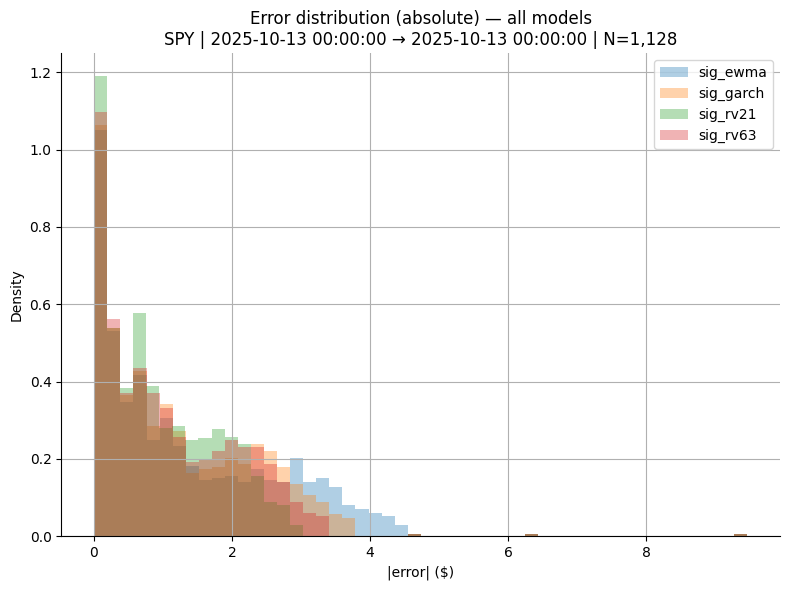

In [24]:
# --- Overlaid histogram of abs errors for all models ---
fig, ax = plt.subplots()

plotted = 0
for m in models:
    e = opt.get(f"err_{m}")
    if e is None: 
        continue
    e = e.dropna().abs()
    if len(e)==0: 
        continue
    ax.hist(e, bins=50, alpha=0.35, label=m, density=True)
    plotted += 1

ax.set_title(title("Error distribution (absolute) — all models"))
ax.set_xlabel("|error| ($)")
ax.set_ylabel("Density")
if plotted>0:
    ax.legend()

p_err_dist = REPORTS / "fig_error_dist.png"
fig.tight_layout()
fig.savefig(p_err_dist, dpi=160)
print("Saved:", p_err_dist)
plt.show()


Saved: reports\fig_error_by_tenor.png


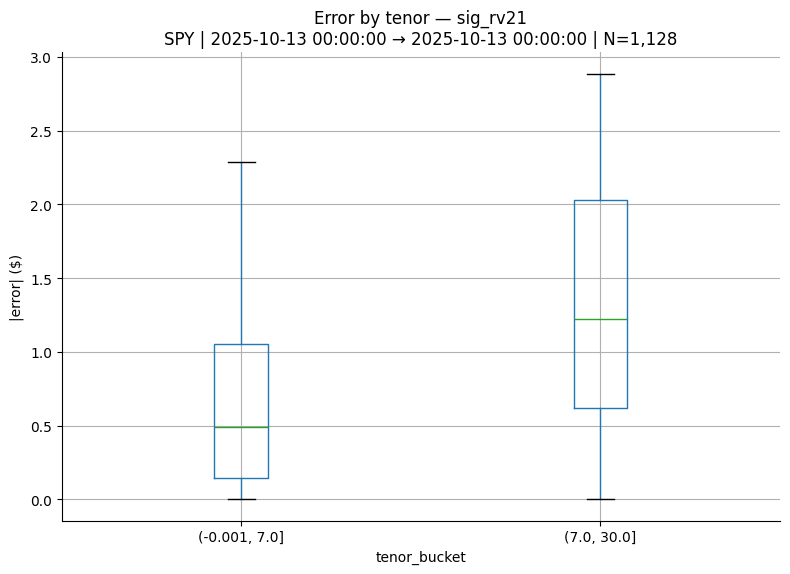

In [14]:
# --- Boxplot of abs error by tenor bucket for best model ---
have_tenor = "tenor_bucket" in opt.columns
if have_tenor:
    e = opt[f"err_{best_model}"].abs()
    df = opt.loc[e.notna(), ["tenor_bucket"]].copy()
    df["abs_err_best"] = e.dropna()
    order = (df.groupby("tenor_bucket")["abs_err_best"].median()
               .sort_values().index.tolist())
    fig, ax = plt.subplots()
    df.boxplot(column="abs_err_best", by="tenor_bucket", ax=ax, showfliers=False)
    ax.set_title(title(f"Error by tenor — {best_model}"))
    ax.set_xlabel("tenor_bucket")
    ax.set_ylabel("|error| ($)")
    # pandas puts a suptitle automatically
    fig.suptitle("")
    p_tenor = REPORTS / "fig_error_by_tenor.png"
    fig.tight_layout()
    fig.savefig(p_tenor, dpi=160)
    print("Saved:", p_tenor)
    plt.show()
else:
    print("No tenor_bucket column; skipping tenor plot.")


Saved: reports\fig_error_by_mny.png


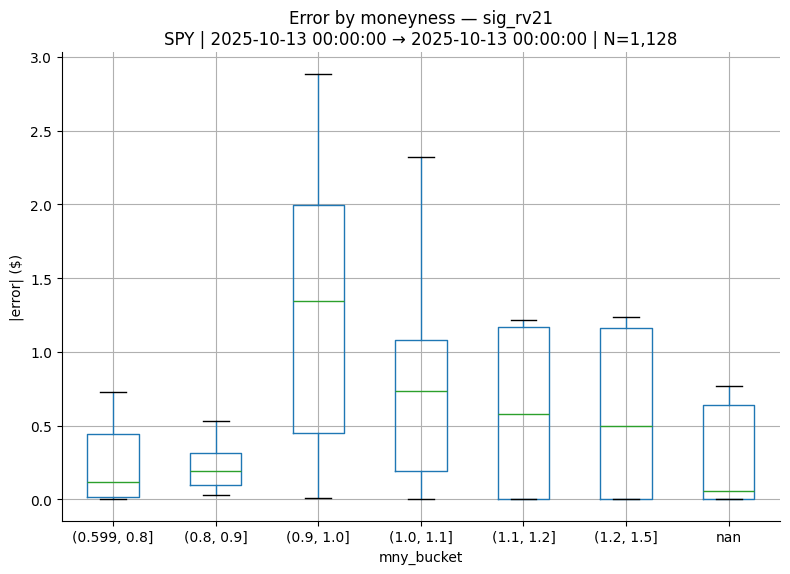

In [15]:
# --- Boxplot of abs error by moneyness bucket for best model ---
have_mny = "mny_bucket" in opt.columns
if have_mny:
    e = opt[f"err_{best_model}"].abs()
    df = opt.loc[e.notna(), ["mny_bucket"]].copy()
    df["abs_err_best"] = e.dropna()
    order = (df.groupby("mny_bucket")["abs_err_best"].median()
               .sort_values().index.tolist())
    fig, ax = plt.subplots()
    df.boxplot(column="abs_err_best", by="mny_bucket", ax=ax, showfliers=False)
    ax.set_title(title(f"Error by moneyness — {best_model}"))
    ax.set_xlabel("mny_bucket")
    ax.set_ylabel("|error| ($)")
    fig.suptitle("")
    p_mny = REPORTS / "fig_error_by_mny.png"
    fig.tight_layout()
    fig.savefig(p_mny, dpi=160)
    print("Saved:", p_mny)
    plt.show()
else:
    print("No mny_bucket column; skipping moneyness plot.")


Saved: reports\fig_market_vs_model.png


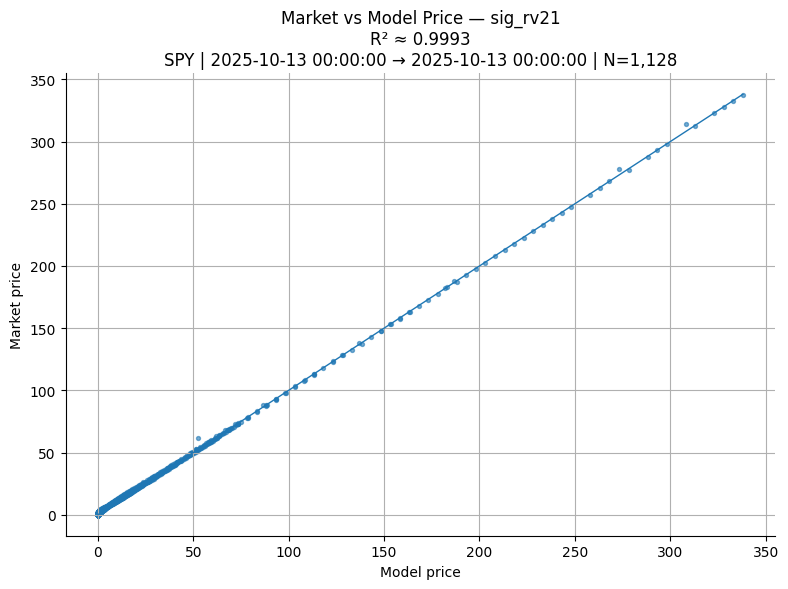

In [16]:
# --- Scatter: market price vs model price for best model ---
mp_col = f"price_{best_model}"
if mp_col not in opt.columns:
    raise KeyError(f"{mp_col} not found. Re-run notebook 03 to compute model prices.")

df = opt[[mp_col, "price"]].dropna().copy()
x = df[mp_col].values
y = df["price"].values

# Compute R^2 to annotate
if len(x)>1:
    r2 = 1.0 - np.sum((y-x)**2)/np.sum((y-y.mean())**2)
else:
    r2 = np.nan

fig, ax = plt.subplots()
ax.scatter(x, y, s=8, alpha=0.6)
# 1:1 line
mn = float(min(x.min(), y.min()))
mx = float(max(x.max(), y.max()))
ax.plot([mn, mx], [mn, mx], lw=1)

ax.set_title(title(f"Market vs Model Price — {best_model}\nR² ≈ {r2:.4f}"))
ax.set_xlabel("Model price")
ax.set_ylabel("Market price")

p_mv = REPORTS / "fig_market_vs_model.png"
fig.tight_layout()
fig.savefig(p_mv, dpi=160)
print("Saved:", p_mv)
plt.show()


In [21]:
# --- REPAIR: compute best model, err_best, price_best, and buckets if missing ---

import json
import numpy as np
import pandas as pd
from pathlib import Path

# a) Identify all error / price columns coming from Notebook 4
err_cols   = [c for c in opt.columns if c.startswith("err_")]
price_cols = [c for c in opt.columns if c.startswith("price_")]

if not err_cols:
    raise ValueError("No err_* columns found. Re-run Notebook 4 to create pricing errors.")

# b) Decide best model
best_model = None

# If you saved best model earlier:
best_model_json = Path("reports/best_model.json")
if best_model_json.exists():
    try:
        best_model = json.loads(best_model_json.read_text())["best_model"]
    except Exception:
        best_model = None

# Otherwise pick by lowest RMSE across err_* columns
if best_model is None:
    rmse_by_model = (
        opt[err_cols].apply(lambda s: np.sqrt((s**2).mean())).sort_values()
    )
    err_best_col = rmse_by_model.index[0]     # e.g. 'err_sig_rv21'
    best_model   = err_best_col.replace("err_", "")   # e.g. 'sig_rv21'
else:
    err_best_col = f"err_{best_model}"

print("Best model resolved as:", best_model)

# c) Create 'err_best' and 'price_best' if they don't exist
if "err_best" not in opt.columns:
    if err_best_col not in opt.columns:
        raise KeyError(f"{err_best_col} not in opt.columns")
    opt["err_best"] = opt[err_best_col]

price_best_col = f"price_{best_model}"
if "price_best" not in opt.columns and price_best_col in opt.columns:
    opt["price_best"] = opt[price_best_col]

# d) Buckets (tenor and moneyness) if missing
if "tenor_bucket" not in opt.columns:
    # T is in years (you created this earlier); adjust edges if you prefer
    opt["tenor_bucket"] = pd.cut(opt["T"]*365, [0, 7, 30, 90, 180, 365, 9999])

if "mny_bucket" not in opt.columns:
    # moneyness = strike / spot, if not already present
    if "moneyness" not in opt.columns:
        opt["moneyness"] = opt["strike"] / opt["S"]
    opt["mny_bucket"] = pd.cut(opt["moneyness"], [0.6, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5])


Best model resolved as: sig_rv21


In [8]:
# --- Small summary tables for the report ---
tables = {}

if "tenor_bucket" in opt.columns:
    tb = (opt.assign(abs_err_best=opt[f"err_{best_model}"].abs())
             .dropna(subset=["abs_err_best"])
             .groupby("tenor_bucket")["abs_err_best"]
             .agg(count="size", MAE="mean", RMSE=lambda s: np.sqrt((s**2).mean()))
             .reset_index())
    tables["tenor"] = tb

if "mny_bucket" in opt.columns:
    mb = (opt.assign(abs_err_best=opt[f"err_{best_model}"].abs())
             .dropna(subset=["abs_err_best"])
             .groupby("mny_bucket")["abs_err_best"]
             .agg(count="size", MAE="mean", RMSE=lambda s: np.sqrt((s**2).mean()))
             .reset_index())
    tables["mny"] = mb

for k, t in tables.items():
    display(t.style.format({"MAE":"{:.4f}", "RMSE":"{:.4f}"}))


,tenor_bucket,count,MAE,RMSE
0,"(-0.001, 7.0]",620,0.6682,0.9471
1,"(7.0, 30.0]",508,1.3024,1.5883


,mny_bucket,count,MAE,RMSE
0,"(0.599, 0.8]",60,0.2352,0.3414
1,"(0.8, 0.9]",82,0.2298,0.2870
2,"(0.9, 1.0]",572,1.2802,1.5304
3,"(1.0, 1.1]",378,0.7620,1.0420
4,"(1.1, 1.2]",6,0.5917,0.8335
5,"(1.2, 1.5]",6,0.5760,0.8151
6,nan,24,0.6501,1.6524


In [9]:
# --- Generate quick bullets summarizing results ---
bullets = []

# Best model line
rmse = float(leader.loc[leader["model"]==best_model, "RMSE"].iloc[0])
nrows = int(leader.loc[leader["model"]==best_model, "N"].iloc[0])
bullets.append(f"Best model: **{best_model}** (RMSE ≈ {rmse:.4f}, N={nrows}).")

# Tenor pattern (if present)
if "tenor" in tables:
    t = tables["tenor"].sort_values("MAE")
    bullets.append(f"By tenor, lowest MAE: **{t.iloc[0]['tenor_bucket']}**; "
                   f"highest: **{t.iloc[-1]['tenor_bucket']}**.")

# Moneyness pattern (if present)
if "mny" in tables:
    m = tables["mny"].sort_values("MAE")
    bullets.append(f"By moneyness, easiest (lowest MAE): **{m.iloc[0]['mny_bucket']}**; "
                   f"hardest: **{m.iloc[-1]['mny_bucket']}**.")

# Distribution quantiles
abs_err = opt[f"err_{best_model}"].abs().dropna()
if len(abs_err):
    bullets.append(f"Median |error| ≈ {abs_err.median():.4f}; 90th pct ≈ {abs_err.quantile(0.90):.4f}.")

# Save bullets
txt_path = REPORTS / "summary_bullets.txt"
with open(txt_path, "w", encoding="utf-8") as f:
    for b in bullets:
        f.write(f"- {b}\n")
print("Saved:", txt_path)

bullets


Saved: reports\summary_bullets.txt


['Best model: **sig_rv21** (RMSE ≈ 1.2764, N=1128).',
 'By tenor, lowest MAE: **(-0.001, 7.0]**; highest: **(7.0, 30.0]**.',
 'By moneyness, easiest (lowest MAE): **(0.8, 0.9]**; hardest: **(0.9, 1.0]**.',
 'Median |error| ≈ 0.7396; 90th pct ≈ 2.1481.']

In [22]:
from pathlib import Path
reports = Path("reports")
reports.mkdir(parents=True, exist_ok=True)

# Make sure these files actually exist (re-run your plotting cells if needed)
fig_error_dist  = reports / "fig_error_dist.png"
fig_error_tenor = reports / "fig_error_by_tenor.png"
fig_error_mny   = reports / "fig_error_by_mny.png"
fig_mv_model    = reports / "fig_market_vs_model.png"

for p in [fig_error_dist, fig_error_tenor, fig_error_mny, fig_mv_model]:
    print(p, "exists:", p.exists())

# Build simple leaderboard (top 5)
err_cols = [c for c in opt.columns if c.startswith("err_")]
lb = pd.DataFrame({
    "model": [c.replace("err_", "") for c in err_cols],
    "N":     [opt[c].notna().sum() for c in err_cols],
    "MAE":   [opt[c].abs().mean() for c in err_cols],
    "RMSE":  [np.sqrt((opt[c]**2).mean()) for c in err_cols],
    "MedianAE": [opt[c].abs().median() for c in err_cols],
}).sort_values("RMSE").head(5)

# HTML content: NOTE src uses filenames only because HTML is inside 'reports/'
html = f"""
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>SPY Option Pricing Summary</title>
<style>
body {{ font-family: Arial, sans-serif; margin: 24px; }}
table {{ border-collapse: collapse; margin: 12px 0; }}
th, td {{ border: 1px solid #ddd; padding: 6px 10px; }}
h1 {{ margin-top: 0; }}
img {{ max-width: 900px; display: block; margin: 8px 0 24px 0; }}
</style>
</head>
<body>

<h1>SPY Option Pricing Summary</h1>
<p><b>Generated:</b> {pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")} |
<b>Best model:</b> {best_model}</p>

<h2>Leaderboard (top 5 by RMSE)</h2>
{lb.to_html(index=False)}

<h2>Figures</h2>
<p><b>Error distribution (all models)</b></p>
<img src="fig_error_dist.png" alt="Error dist">

<p><b>Error by tenor (best model)</b></p>
<img src="fig_error_by_tenor.png" alt="Error by tenor">

<p><b>Error by moneyness (best model)</b></p>
<img src="fig_error_by_mny.png" alt="Error by mny">

<p><b>Market vs Model (best model)</b></p>
<img src="fig_market_vs_model.png" alt="Market vs Model">

<h2>Per-tenor summary</h2>
{tenor_summary.to_html(index=False)}

<h2>Per-moneyness summary</h2>
{mny_summary.to_html(index=False)}

</body>
</html>
"""

out_html = reports / "summary_overview.html"
out_html.write_text(html, encoding="utf-8")
print("Wrote:", out_html)


reports\fig_error_dist.png exists: True
reports\fig_error_by_tenor.png exists: True
reports\fig_error_by_mny.png exists: True
reports\fig_market_vs_model.png exists: True
Wrote: reports\summary_overview.html


C:\Users\biboz\Documents\Projects\ftse-options-efficiency-vol-forecasting\venv311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [11]:
# --- Sanity checks ---
need = [
    REPORTS/"fig_error_dist.png",
    REPORTS/"fig_market_vs_model.png",
    REPORTS/"summary_bullets.txt",
    REPORTS/"summary_overview.html",
]
for p in need:
    print(p, "exists:", p.exists())

print("\nOpen this in your browser:")
print((REPORTS/"summary_overview.html").resolve())


reports\fig_error_dist.png exists: True
reports\fig_market_vs_model.png exists: True
reports\summary_bullets.txt exists: True
reports\summary_overview.html exists: True

Open this in your browser:
C:\Users\biboz\Documents\Projects\ftse-options-efficiency-vol-forecasting\reports\summary_overview.html


In [12]:
print('Run this in PowerShell (from repo root) if you want a quick commit:\n')
print('git add reports/* && git commit -m "Summary report + figures" && git push')


Run this in PowerShell (from repo root) if you want a quick commit:

git add reports/* && git commit -m "Summary report + figures" && git push


In [17]:
from pathlib import Path

REP = Path("reports")
print("HTML present:", (REP/"summary_overview.html").exists())
print("\nPNG files in reports/:")
for p in sorted(REP.glob("fig_*.png")):
    print(f"- {p.name}  ({p.stat().st_size/1024:.1f} KB)")


HTML present: True

PNG files in reports/:
- fig_error_by_mny.png  (43.0 KB)
- fig_error_by_tenor.png  (36.3 KB)
- fig_error_dist.png  (43.9 KB)
- fig_market_vs_model.png  (68.6 KB)


In [23]:
print("HTML:", (Path("reports")/"summary_overview.html").exists())
for p in ["fig_error_dist.png","fig_error_by_tenor.png","fig_error_by_mny.png","fig_market_vs_model.png"]:
    print(p, "->", (Path("reports")/p).exists())
print("Columns present:", "err_best" in opt, "price_best" in opt, "tenor_bucket" in opt, "mny_bucket" in opt)


HTML: True
fig_error_dist.png -> True
fig_error_by_tenor.png -> True
fig_error_by_mny.png -> True
fig_market_vs_model.png -> True
Columns present: True True True True


In [26]:
from pathlib import Path
import base64

R = Path("reports")
def inline_img(name, title):
    b = (R/name).read_bytes()
    b64 = base64.b64encode(b).decode("ascii")
    return f'<h3>{title}</h3>\n<img alt="{name}" src="data:image/png;base64,{b64}" style="max-width:900px;width:100%;">'

fig_html = "\n".join([
    inline_img("fig_error_dist.png",   "Error distribution (all models)"),
    inline_img("fig_error_by_tenor.png","Error by tenor (best model)"),
    inline_img("fig_error_by_mny.png",  "Error by moneyness (best model)"),
    inline_img("fig_market_vs_model.png","Market vs Model (best model)"),
])

leader_html = leaderboard_html if 'leaderboard_html' in globals() else ""
tenor_html  = tenor_summary.to_html(index=False) if 'tenor_summary' in globals() else ""
mny_html    = mny_summary.to_html(index=False)   if 'mny_summary' in globals() else ""

html = f"""
<h1>SPY Option Pricing Summary</h1>
<p><b>Generated:</b> now &nbsp;|&nbsp; <b>Best model:</b> {globals().get('best_model','best')}</p>

<h2>Leaderboard (top 5 by RMSE)</h2>
{leader_html}

<h2>Figures</h2>
{fig_html}

<h2>Per-tenor summary</h2>
{tenor_html}

<h2>Per-moneyness summary</h2>
{mny_html}

<h2>Key takeaways</h2>
<pre>{Path(R/'summary_bullets.txt').read_text(encoding='utf-8') if (R/'summary_bullets.txt').exists() else ''}</pre>
"""

out = R / "summary_overview.html"
out.write_text(html, encoding="utf-8")
print("Wrote (inline):", out)


Wrote (inline): reports\summary_overview.html
